In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns


# Load and Preprocess Data 

In [29]:
df = pd.read_csv('balanced_dataset.csv')

# Modify labels: 0 -> 1, others (1,2,3,4) -> 0
df['label'] = df['label'].apply(lambda x: 0 if x == 1 else 1)

# Preprocess data
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['label']))
y = df['label'].values

# Feature Selection using Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = rf.feature_importances_
feature_names = df.drop(columns=['label']).columns

# Select top k features
k = 4
top_features = [feature for feature, importance in sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)[:k]]

# Reduce dataset to selected features
X_selected = df[top_features].values
X_selected = scaler.fit_transform(X_selected)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


print(top_features)


['total_methods', 'num_files', 'file_size_kb', 'num_permissions']


# ANFIS Model

In [30]:
class ANFIS(nn.Module):
    def __init__(self, input_dim, num_rules):
        super(ANFIS, self).__init__()
        self.num_rules = num_rules
        
        # Fuzzy Membership Parameters (Gaussian functions) - Ensuring Stability
        self.mu = nn.Parameter(torch.randn(input_dim, num_rules))
        self.sigma = nn.Parameter(torch.randn(input_dim, num_rules).abs() + 1e-6)  # Avoiding zero sigma
        
        # Output Layer
        self.linear = nn.Linear(num_rules, 1)  # Single output for binary classification
    
    def forward(self, x):
        # Gaussian Membership Functions - Adding Stability
        membership = torch.exp(-((x.unsqueeze(2) - self.mu) ** 2) / (2 * self.sigma ** 2 + 1e-6))
        
        # Rule Activation (Product of Memberships)
        rule_activation = torch.prod(membership, dim=1)
        
        # Normalize Rule Activations - Prevent Division by Zero
        sum_activation = torch.sum(rule_activation, dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        rule_strengths = rule_activation / sum_activation
        
        # Weighted Rule Outputs
        output = self.linear(rule_strengths)
        
        return torch.sigmoid(output).squeeze()  # Apply sigmoid for binary classification

# Initialize model
input_dim = X_train.shape[1]
num_rules = 5  # Number of fuzzy rules
model = ANFIS(input_dim, num_rules)


# training

In [31]:
class_weight = torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])])
criterion = nn.BCELoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop
num_epochs = 2500 # Increase training epochs for better convergence
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)  # Use adjusted loss function
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/2500], Loss: 0.9946
Epoch [20/2500], Loss: 0.9883
Epoch [30/2500], Loss: 0.9820
Epoch [40/2500], Loss: 0.9753
Epoch [50/2500], Loss: 0.9679
Epoch [60/2500], Loss: 0.9597
Epoch [70/2500], Loss: 0.9513
Epoch [80/2500], Loss: 0.9436
Epoch [90/2500], Loss: 0.9354
Epoch [100/2500], Loss: 0.9271
Epoch [110/2500], Loss: 0.9186
Epoch [120/2500], Loss: 0.9101
Epoch [130/2500], Loss: 0.9017
Epoch [140/2500], Loss: 0.8928
Epoch [150/2500], Loss: 0.8836
Epoch [160/2500], Loss: 0.8733
Epoch [170/2500], Loss: 0.8591
Epoch [180/2500], Loss: 0.8410
Epoch [190/2500], Loss: 0.8265
Epoch [200/2500], Loss: 0.8131
Epoch [210/2500], Loss: 0.8028
Epoch [220/2500], Loss: 0.7960
Epoch [230/2500], Loss: 0.7902
Epoch [240/2500], Loss: 0.7844
Epoch [250/2500], Loss: 0.7789
Epoch [260/2500], Loss: 0.7734
Epoch [270/2500], Loss: 0.7679
Epoch [280/2500], Loss: 0.7626
Epoch [290/2500], Loss: 0.7580
Epoch [300/2500], Loss: 0.7542
Epoch [310/2500], Loss: 0.7508
Epoch [320/2500], Loss: 0.7475
Epoch [330/2500],

Test Loss: 0.4559
Precision: 0.8523


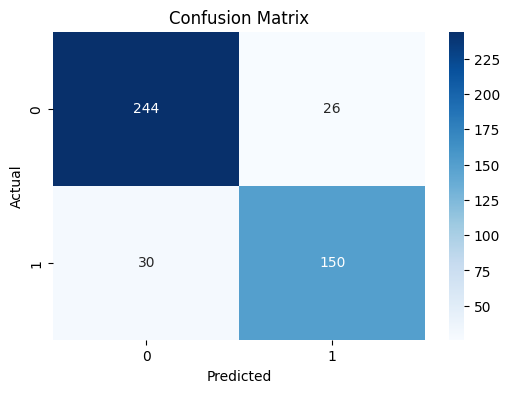

Confusion Matrix:
[[244  26]
 [ 30 150]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90       270
         1.0       0.85      0.83      0.84       180

    accuracy                           0.88       450
   macro avg       0.87      0.87      0.87       450
weighted avg       0.88      0.88      0.88       450



In [32]:
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert predictions to binary labels
y_pred_class = (y_pred > 0.5).int().numpy()
y_test_numpy = y_test.numpy()

# Calculate precision
precision = precision_score(y_test_numpy, y_pred_class, average='binary', zero_division=1)
print(f'Precision: {precision:.4f}')

conf_matrix = confusion_matrix(y_test_numpy, y_pred_class)
# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
# Generate confusion matrix

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_numpy, y_pred_class, zero_division=1))

# Testing

In [33]:
def test_model(sample_input, true_labels=None):
    """
    Function to test the trained ANFIS model on new inputs and compute accuracy.

    Args:
        sample_input (numpy array or torch tensor): Feature data to classify.
        true_labels (numpy array or torch tensor, optional): True labels for accuracy calculation.

    Returns:
        dict: Dictionary containing probabilities, predictions, confidence, and accuracy.
    """
    # Convert input to tensor if it's a NumPy array
    if isinstance(sample_input, np.ndarray):
        sample_input = torch.tensor(sample_input, dtype=torch.float32)

    # Ensure input is 2D (batch format)
    if sample_input.dim() == 1:
        sample_input = sample_input.unsqueeze(0)

    # Make prediction without tracking gradients
    with torch.no_grad():
        probabilities = model(sample_input)  # Get probability scores

    # Convert probabilities to binary classes
    predicted_classes = (probabilities > 0.5).int().numpy()
    probabilities = probabilities.numpy()

    # Compute confidence scores (how far from 0.5 threshold)
    confidence = np.abs(probabilities - 0.5) * 2  # Range: 0 to 1

    # Compute accuracy if true labels are provided
    accuracy = None
    if true_labels is not None:
        if isinstance(true_labels, np.ndarray):
            true_labels = torch.tensor(true_labels, dtype=torch.float32)

        correct_predictions = (predicted_classes.flatten() == true_labels.numpy()).sum()
        accuracy = correct_predictions / len(true_labels) * 100  # Convert to percentage

    # Organize results into a dictionary
    results = {
        "probabilities": probabilities.flatten(),
        "predicted_classes": predicted_classes.flatten(),
        "confidence": confidence.flatten(),
        "accuracy": accuracy,  # Shows None if no true labels are given
    }

    return results


test_sample = X_test[7:15]

# Get predictions
predictions = test_model(test_sample, true_labels=y_test[7:15])

# Display results
for i in range(len(test_sample)):
    print(f"Sample {i+1}:")
    print(f"  Probability: {predictions['probabilities'][i]:.4f}")
    print(f"  Predicted Class: {predictions['predicted_classes'][i]}")
    print(f"  Confidence: {predictions['confidence'][i]:.2%}")
    print("-" * 30)
    
print(f"Overall Accuracy: {predictions['accuracy']:.2f}%")



Sample 1:
  Probability: 0.0582
  Predicted Class: 0
  Confidence: 88.37%
------------------------------
Sample 2:
  Probability: 0.9531
  Predicted Class: 1
  Confidence: 90.61%
------------------------------
Sample 3:
  Probability: 0.0542
  Predicted Class: 0
  Confidence: 89.16%
------------------------------
Sample 4:
  Probability: 0.2713
  Predicted Class: 0
  Confidence: 45.74%
------------------------------
Sample 5:
  Probability: 0.9207
  Predicted Class: 1
  Confidence: 84.14%
------------------------------
Sample 6:
  Probability: 0.1954
  Predicted Class: 0
  Confidence: 60.92%
------------------------------
Sample 7:
  Probability: 0.8830
  Predicted Class: 1
  Confidence: 76.60%
------------------------------
Sample 8:
  Probability: 0.0553
  Predicted Class: 0
  Confidence: 88.94%
------------------------------
Overall Accuracy: 87.50%


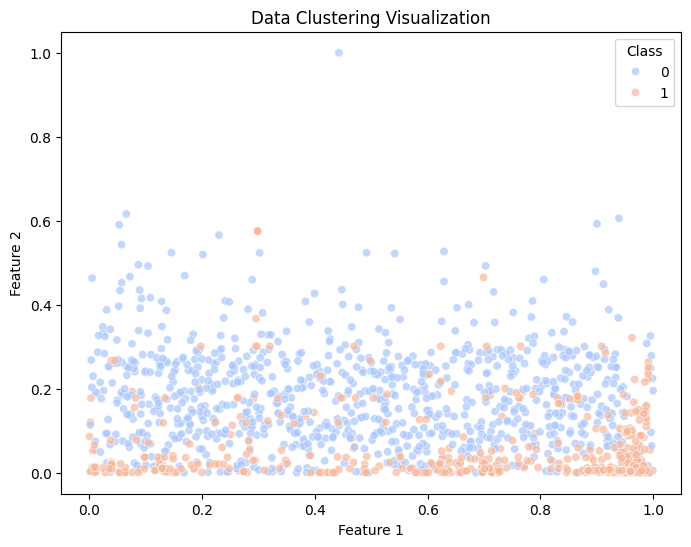

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Clustering Visualization')
plt.legend(title='Class')
plt.show()

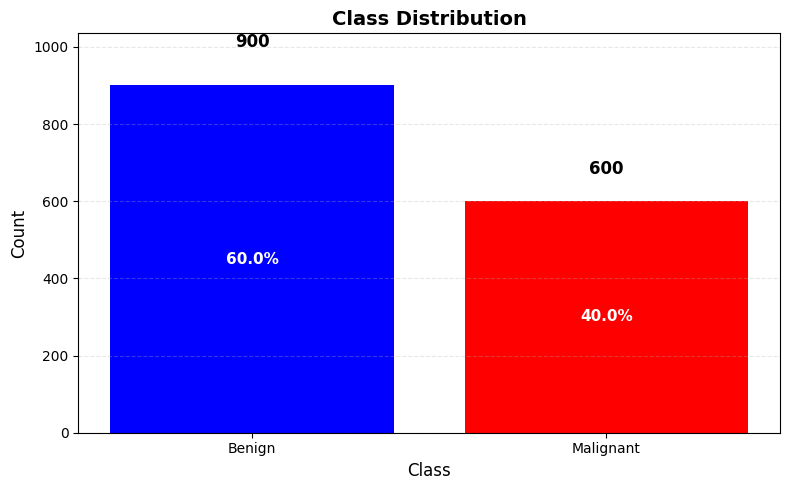


Class Distribution Summary:
Benign: 900 samples (60.0%)
Malignant: 600 samples (40.0%)
Total: 1,500 samples


In [36]:
plt.figure(figsize=(8, 5))
class_counts = pd.Series(y).value_counts()

# Create bar plot
bars = plt.bar(class_counts.index, class_counts.values, color=['blue', 'red'])

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1*height,
             f'{int(height):,}',  # Format with comma for thousands
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Set labels and title
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)

# Ensure there's enough room for the labels
plt.ylim(0, max(class_counts.values) * 1.15)  # Add 15% padding at the top

# Add percentage labels inside bars
total = class_counts.sum()
for i, bar in enumerate(bars):
    percentage = (class_counts.values[i] / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{percentage:.1f}%', 
             ha='center', va='center', fontsize=11, 
             color='white', fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# Print summary statistics
print("\nClass Distribution Summary:")
print(f"Benign: {class_counts.get(0, 0):,} samples ({class_counts.get(0, 0)/total*100:.1f}%)")
print(f"Malignant: {class_counts.get(1, 0):,} samples ({class_counts.get(1, 0)/total*100:.1f}%)")
print(f"Total: {total:,} samples")